In [1]:
!mkdir models
!pip install -q numpy opencv-python matplotlib tensorflow

!bash ./load_models.sh

mkdir: cannot create directory ‘models’: File exists
--2020-05-14 20:00:32--  https://raw.githubusercontent.com/metalwhale/hand_tracking/master/hand_landmark.tflite
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.204.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.204.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11404748 (11M) [application/octet-stream]
Saving to: ‘./models/hand_landmark.tflite’

./models/hand_landm 100%[===================>]  10.88M  3.49MB/s    in 3.1s    

2020-05-14 20:00:38 (3.49 MB/s) - ‘./models/hand_landmark.tflite’ saved [11404748/11404748]

--2020-05-14 20:00:38--  https://raw.githubusercontent.com/google/mediapipe/master/mediapipe/models/hand_landmark_3d.tflite
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.204.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.204.133|:443... connected.
HTTP request sent, await

In [ ]:
!wget --quiet https://upload.wikimedia.org/wikipedia/commons/9/99/JPEG_20190317_010417.jpg -O ./data/test_img.jpg
    

In [86]:
# !pip install "git+https://github.com/javadba/mpld3@display_fix"
import mpld3
mpld3.enable_notebook()
mpld3.disable_notebook()

In [1]:
from hand_tracker import HandTracker
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
%matplotlib inline

In [2]:
palm_model_path = "./models/palm_detection.tflite"
landmark_model_path = "./models/hand_landmark.tflite"
anchors_path = "./data/anchors.csv" 

In [3]:
img = cv2.imread('./data/test_img.jpg')[:,:,::-1]
img = cv2.imread('/home/ausaf/Pictures/Webcam/hand.jpg', -1)

In [4]:
# box_shift determines 
detector = HandTracker(palm_model_path, landmark_model_path, anchors_path,
                       box_shift=0.2, box_enlarge=1.3)

/home/ausaf/Documents/cvhandrehab/hand_tracker.py:95: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x) )


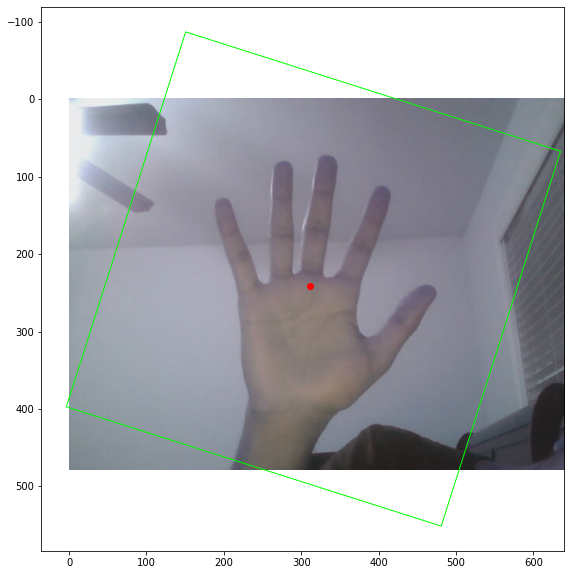

In [5]:
kp, box = detector(img)

f,ax = plt.subplots(1,1, figsize=(10, 10))

ax.imshow(img)
n = 9
ax.scatter(kp[n,0], kp[n,1], color='#ff0000')
ax.add_patch(Polygon(box, color="#00ff00", fill=False))

In [132]:
!pip install scikit-learn

     |████████████████████████████████| 7.2 MB 287 kB/s eta 0:00:01
     |████████████████████████████████| 298 kB 7.3 MB/s eta 0:00:01


In [6]:
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
from scipy.signal import savgol_filter
import numpy as np
import pickle 
from fastdtw import fastdtw 
from matplotlib.lines import Line2D 
from sklearn import preprocessing
x = np.array(pickle.load(open('./poses/norm/norm1.pose', 'rb')))

In [7]:
x[1,0,:].shape
x[:,0,1].shape

(681,)

In [8]:
filtered = x.copy()
for i in range(21): 
    filtered[:,i,0] = savgol_filter(x[:,i,0], 13, 2)
    filtered[:,i,1] = savgol_filter(x[:,i,1], 13, 2)
pickle.dump(filtered, open('./poses/norm/norm1_filter.pose', 'wb'))

In [9]:
filtered[0,0,0] - x[0,0,0]

-2.4388016892610267

In [10]:
def smooth(data, m=9,n=3): 
    filtered = data.copy()
    for i in range(21): 
        filtered[:,i,0] = savgol_filter(data[:,i,0], m, n)
        filtered[:,i,1] = savgol_filter(data[:,i,1], m, n)
    return filtered

def center(n):
    for k in range(21):
        n[:,k,:] -= n[0,k,:]
    return n


In [11]:
normal = []
bad = []
worst = []

def preprocess(n): 
    n = smooth(n)
    for k in range(21):
        n[:,k,:] = preprocessing.scale(n[:,k,:])
    return n

for i in range(1,5): 
    normal.append( preprocess(np.array(pickle.load(open(f'./poses/norm/norm{i}.pose', 'rb')))  ) )
    bad.append(    preprocess(np.array(pickle.load(open(f'./poses/bad/bad{i}.pose', 'rb')))    ) )
    worst.append(  preprocess(np.array(pickle.load(open(f'./poses/worst/worst{i}.pose', 'rb')))) )

    
result = {}
i = 1
for k in range(21):
    dist1, path = fastdtw(normal[0][:,k,:], normal[i][:,k,:], dist=euclidean)
    dist2, path = fastdtw(normal[0][:,k,:], bad[i][:,k,:], dist=euclidean)
    dist3, path = fastdtw(normal[0][:,k,:], worst[i][:,k,:], dist=euclidean)
    
    result[k] = [[dist1],[dist2],[dist3]]
    

## DTW distance

In [12]:
def dtw_dist(a,kp=0): 
    dist,path = fastdtw(normal[0][:,kp,:], a[:,kp,:], dist=euclidean)
    return np.around(dist,1)

In [13]:
n = np.array(pickle.load(open(f'./poses/norm/norm{i}.pose', 'rb')))
n.shape
preprocess(n)[5,k,:]

array([-0.23889719, -0.76015486])

In [14]:
(normal[0][:,1,:] - np.mean(normal[0][:,1,:]))

array([[-0.1362134 , -0.86404539],
       [-0.134113  , -0.8401784 ],
       [-0.1346718 , -0.83101056],
       ...,
       [-0.17425503, -1.39244282],
       [-0.17033023, -1.37517893],
       [-0.16235206, -1.34064167]])

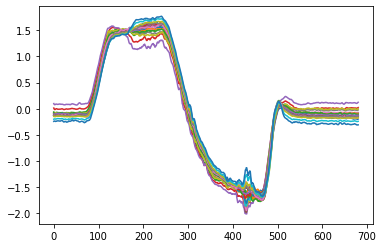

In [15]:
for k in range(21):
    plt.plot(normal[0][:,k,0]) 

## Keypoint Trajectory

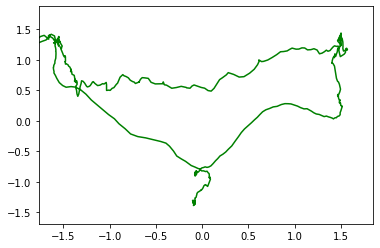

In [16]:
k = 2
fig = plt.figure()
ax = fig.add_subplot(111)

x = worst[2][:,k,0]
y = worst[2][:,k,1]

ax.set_xlim(min(x), max(x))
ax.set_ylim(min(y), max(y))

line = Line2D(normal[0][:,k,0], normal[0][:,k,1],c='green') 
ax.add_line(line)
plt.show()
#plt.scatter(bad[0][:,k,0], bad[0][:,k,1], s=8, c='orange') 
#plt.scatter(worst[0][:,k,0], worst[0][:,k,1], s=8, c='red') 

## Normalized Jerk Score 
![Image](./njs.png)


----- NORMAL -----

0 g 1.8003799357776443e-06 8.01670759172025e-06
1 g 1.9167981442762035e-06 8.834787798735433e-06
2 g 2.185593680751177e-05 3.564778196109734e-05
3 g 1.9648734058647686e-06 8.077151402076842e-06

----- BAD -----

0 y 1.9977662637060522e-06 7.574047738115291e-06
1 y 2.833725631226456e-06 8.646953876004945e-06
2 y 2.5645267222700366e-06 1.105521737243572e-05
3 y 3.3333229816675993e-06 9.725748498294826e-06

----- WORST -----

0 r 3.6871218903589347e-06 1.205827601621596e-05
1 r 5.571643072636391e-06 9.759765765562217e-06
2 r 3.5478571704047367e-06 9.702147919865487e-06
3 r 4.155642728312678e-06 1.0903171084162105e-05


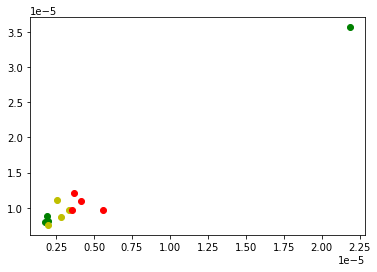

In [18]:
#calculate jerk score given x and y position data 
def njs(data, kp=0): 
    x,y = data[:,kp,0], data[:,kp,1] 
    l = len(x) / 30 
    d = 1/30
    A = (d**5) / (l**2)
    jx,jy = np.diff(x, n=3), np.diff(y, n=3) 
    
    njx, njy = (0.5*np.sum(jx**2 * (A)))**0.5, (0.5*np.sum(jy**2) * A)**0.5
    
    return njx, njy
    #return np.around(njx,1),np.around(njy,1)


data = [normal,bad,worst]
names = ['normal', 'bad', 'worst']
colors = ['g', 'y', 'r']
# mpld3.disable_notebook()
j = []
for a in range(3): 
    v = a
    name = names[a]
    a = data[a]
    jx = [] 
    jy = []
    d = []
    print(f'\n----- {name.upper()} -----\n')
    for i in range(len(a)):
        
        x,y = a[i][:,k,0], a[i][:,k,1]
        
        njx,njy = njs(a[i], kp=0)
        jx.append(njx)
        jy.append(njy)
        d.append(dtw_dist(a[i],kp=k))
        print(i,colors[v],njx,njy)
        
    #plt.plot(d,colors[v])
    plt.scatter(jx,jy,c=colors[v])

plt.savefig('j.png')
        

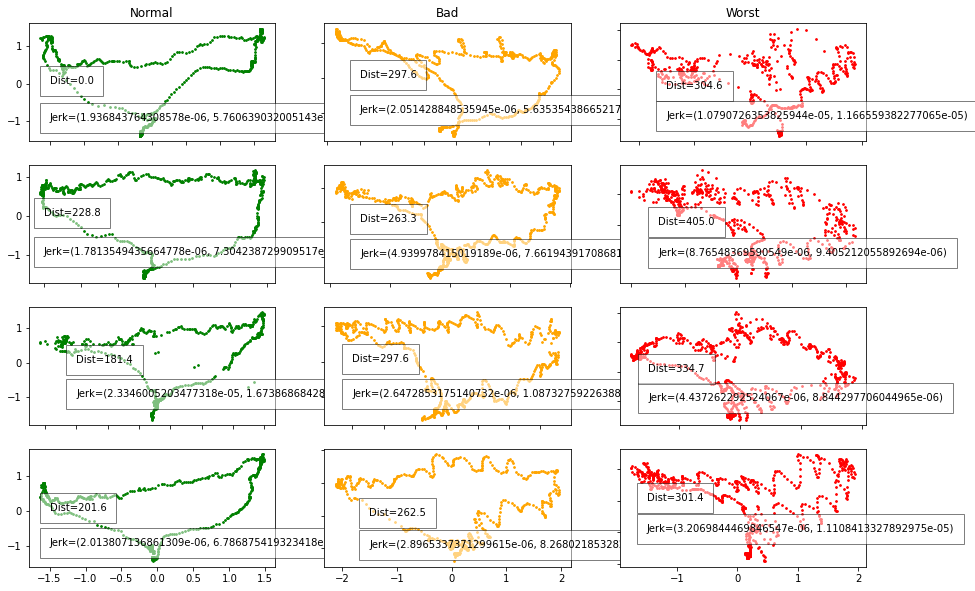

In [19]:
fig, axs = plt.subplots(4, 3)
fig.set_size_inches(15,10)

axs[0, 0].set_title('Normal')
axs[0, 1].set_title('Bad')
axs[0, 2].set_title('Worst')


data = [normal,bad,worst]
colors = ['g', 'orange', 'r']

k = 1
for i in range(3):
    for j in range(4): 
        axs[j,i].scatter(data[i][j][:,k,0],data[i][j][:,k,1],c=colors[i],s=3)
        #axs[j,i].set_xlabel('hello')    
        axs[j,i].text(-1.5,-1,f'Jerk={njs(data[i][j], kp=k)}',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
        axs[j,i].text(-1.5,0,f'Dist={dtw_dist(data[i][j],kp=k)}',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
        
# ct = 0
# for ax in axs.flat:
#     ct += 1
#     ax.set(xlabel='x-label', ylabel=f'Trial {ct}')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()



In [ ]:
fig.savefig('tgrid.png')


In [ ]:
fig, axs = plt.subplots(4, 3)
fig.set_size_inches(15,10)
fig.suptitle('Keypoint 0 Y Value')
axs[0, 0].set_title('Normal')
axs[0, 1].set_title('Bad')
axs[0, 2].set_title('Worst')


data = [normal,bad,worst]
colors = ['g', 'orange', 'r']

k = 1
for i in range(3):
    for j in range(4): 
        axs[j,i].plot(data[i][j][:,k,0],c=colors[i])
        axs[j,i].text(-1,1,f'Jerk={njs(data[i][j], kp=k)[0]}',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
        
# ct = 0
# for ax in axs.flat:
#     ct += 1
#     ax.set(xlabel='x-label', ylabel=f'Trial {ct}')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()